<a href="https://colab.research.google.com/github/purnomoyusgiantoro/svm_predik_kematangan_pisang/blob/main/svm_predik_kematangan_pisang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python scikit-learn matplotlib

import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import zipfile

In [2]:
# Ganti sesuai lokasi ekstraksi zip kamu
DATASET_ZIP_PATH = "/content/Banana Ripeness Classification Dataset.zip"
DATASET_DIR = "/content/Banana Ripeness Classification Dataset"

# Extract the zip file
with zipfile.ZipFile(DATASET_ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall("/content/")


In [3]:

# Fungsi untuk membaca semua gambar dari folder tertentu
def load_images_from_folder(folder_path):
    X, y = [], []
    IMG_SIZE = (64, 64)
    for label in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, label)
        if not os.path.isdir(class_folder):
            continue
        for file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, file)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, IMG_SIZE)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            X.append(img.flatten())
            y.append(label)
    return np.array(X), np.array(y)

In [26]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from skimage.feature import hog
import os
import cv2
import numpy as np

# === FUNGSI UNTUK EKSTRAKSI FITUR HOG ===
def extract_hog_features(img):
    features = hog(
        img,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        transform_sqrt=True
    )
    return features

# === FUNGSI UNTUK LOAD DATASET ===
def load_images_from_folder(folder):
    X, y = [], []
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        if not os.path.isdir(label_path):
            continue
        for filename in os.listdir(label_path):
            img_path = os.path.join(label_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img_resized = cv2.resize(img_gray, (64, 64))
                hog_feat = extract_hog_features(img_resized)
                X.append(hog_feat)
                y.append(label)
    return np.array(X), np.array(y)

# === LOAD TRAIN, TEST, VALID ===
X_train, y_train = load_images_from_folder(os.path.join(DATASET_DIR, "train"))
X_test, y_test = load_images_from_folder(os.path.join(DATASET_DIR, "test"))
X_valid, y_valid = load_images_from_folder(os.path.join(DATASET_DIR, "valid"))

print(f"Train: {X_train.shape}, Test: {X_test.shape}, Valid: {X_valid.shape}")

# === NORMALISASI (SCALING) ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_valid_scaled = scaler.transform(X_valid)

# === OPSIONAL: PCA UNTUK PERCEPAT LATIHAN ===
pca = PCA(n_components=100, whiten=True)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
X_valid_pca = pca.transform(X_valid_scaled)

# === ENCODE LABEL ===
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)
y_valid_encoded = encoder.transform(y_valid)

# === LATIH MODEL SVM ===
print("Training SVM model...")
svm = SVC(kernel='rbf', C=5.0, gamma='scale', probability=True)
svm.fit(X_train_pca, y_train_encoded)
print("Training selesai ✅")

# === EVALUASI ===
def evaluate_model(X, y_true, dataset_name):
    y_pred = svm.predict(X)
    acc = accuracy_score(y_true, y_pred)
    print(f"\n=== {dataset_name.upper()} DATA REPORT ===")
    print(f"Akurasi: {acc*100:.2f}%")
    print(classification_report(y_true, y_pred, target_names=encoder.classes_))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

# Evaluasi di test dan valid
evaluate_model(X_test_pca, y_test_encoded, "Test")
evaluate_model(X_valid_pca, y_valid_encoded, "Validation")


Train: (11793, 1764), Test: (562, 1764), Valid: (1123, 1764)
Training SVM model...
Training selesai ✅

=== TEST DATA REPORT ===
Akurasi: 91.64%
              precision    recall  f1-score   support

    overripe       0.88      0.88      0.88       113
        ripe       0.91      0.90      0.91       154
      rotten       0.91      0.94      0.92       185
      unripe       0.98      0.94      0.96       110

    accuracy                           0.92       562
   macro avg       0.92      0.91      0.92       562
weighted avg       0.92      0.92      0.92       562

Confusion Matrix:
[[100   7   6   0]
 [  7 139   8   0]
 [  5   5 173   2]
 [  2   2   3 103]]

=== VALIDATION DATA REPORT ===
Akurasi: 92.16%
              precision    recall  f1-score   support

    overripe       0.92      0.89      0.91       229
        ripe       0.89      0.94      0.92       339
      rotten       0.93      0.92      0.93       388
      unripe       0.97      0.92      0.95       167

    ac

Saving musa-acuminata-banana-8f139d59-394a-11ec-91b5-d8c4975e38aa_jpg.rf.9ffa64954f4098ef3126d58e64d372c8.jpg to musa-acuminata-banana-8f139d59-394a-11ec-91b5-d8c4975e38aa_jpg.rf.9ffa64954f4098ef3126d58e64d372c8.jpg
Gambar yang diupload: musa-acuminata-banana-8f139d59-394a-11ec-91b5-d8c4975e38aa_jpg.rf.9ffa64954f4098ef3126d58e64d372c8.jpg


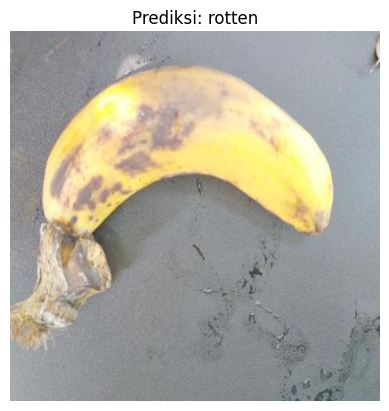

In [39]:
from google.colab import files
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import io
from skimage.feature import hog # Import hog function

# 1️⃣ Upload gambar dari laptop
uploaded = files.upload()

# 2️⃣ Ambil nama file pertama yang diupload
for file_name in uploaded.keys():
    img_path = file_name
    print(f"Gambar yang diupload: {img_path}")

# 3️⃣ Baca dan proses gambar
img = cv2.imread(img_path)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_resized = cv2.resize(img_gray, (64, 64))  # ukuran harus sama seperti saat training

# === APPLY HOG FEATURE EXTRACTION, SCALING AND PCA ===
# Ensure extract_hog_features function is available (defined in a previous cell)
hog_feat = extract_hog_features(img_resized)
# Reshape the feature vector to be a 2D array with one sample
hog_feat_reshaped = hog_feat.reshape(1, -1)
# Ensure scaler and pca objects are available (fitted in a previous cell)
img_scaled = scaler.transform(hog_feat_reshaped)
img_pca = pca.transform(img_scaled)


# 4️⃣ Prediksi menggunakan model SVM kamu
# pastikan variabel `svm` and `encoder` sudah didefinisikan sebelumnya (hasil dari training)
prediction = svm.predict(img_pca) # Use PCA transformed features for prediction
label_pred = encoder.inverse_transform(prediction)

# 5️⃣ Tampilkan hasil
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"Prediksi: {label_pred[0]}")
plt.axis('off')
plt.show()